K-Means

In [657]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [756]:
sql = '''
SELECT *  FROM `eth-tokens.test.clean_avg_with_balances_tokens`
'''

df = client.query(sql).to_dataframe()

In [757]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [758]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [759]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

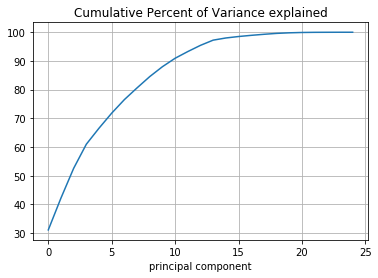

In [760]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

Text(0.5,1,'Calinski Harabaz Scores')

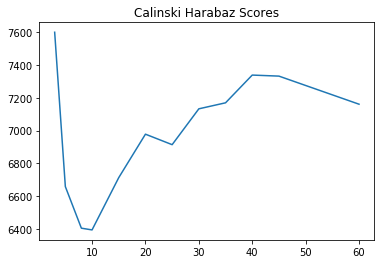

In [761]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [3,5,8,10,15,20,25,30,35,40,45,60]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

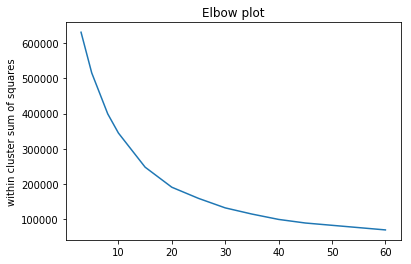

In [762]:
#elbow plot
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [813]:
#optimal number of clusters is around 20
cl = KMeans(40)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [814]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [815]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

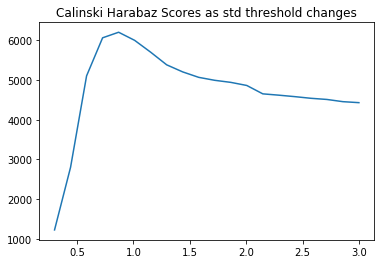

In [816]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [817]:
#empirical best threshold 1 stdev
newresults, labels = remove_outliers(results, cl,1)

In [818]:
%run silhouette_plotter.py
X=results
range_n_clusters = [20]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

<Figure size 432x288 with 0 Axes>

In [769]:
import time
from sklearn.manifold import TSNE
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.049s...
[t-SNE] Computed neighbors for 35917 samples in 10.977s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

Text(0,0.5,'second principcal component')

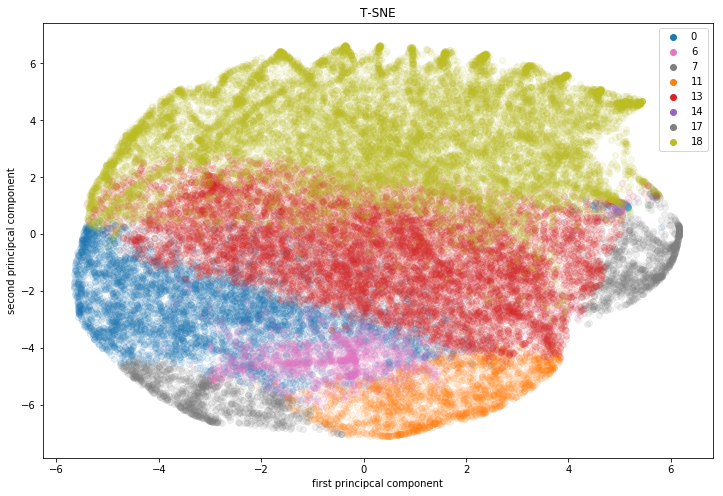

In [770]:
plt.figure(figsize=(12,8))
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <50:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principcal component')
plt.ylabel('second principcal component')

In [771]:
#3d
# time_start = time.time()
# tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(results)

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [772]:

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for c in np.unique(cl.labels_):
#     mask = cl.labels_==c
#     if np.sum(mask) <50:
#         lbl = '_nolegend_'
#     else:
#         lbl = c
#     ax.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], tsne_results[mask][:,2], s=10, alpha=.01,label=lbl)
# leg = plt.legend()
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
# ax.set_xlabel('first principal component')
# ax.set_ylabel('second principal component')
# ax.set_zlabel('third principal component')
# ax.view_init(elev=30, azim=0)
# plt.show()


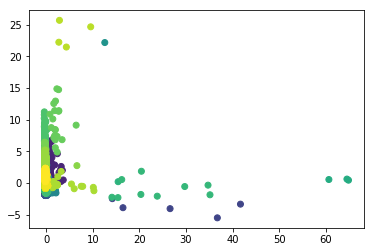

In [819]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
# plt.xlim(0,10)
# plt.ylim(-10,10)

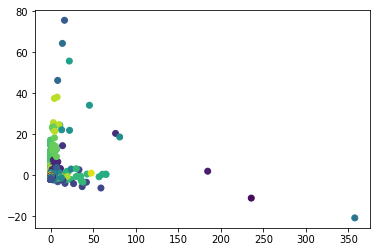

In [820]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [993]:
#recluster after changes
cl = KMeans(20).fit(results)
newcl = KMeans(20).fit(newresults)

In [994]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [995]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

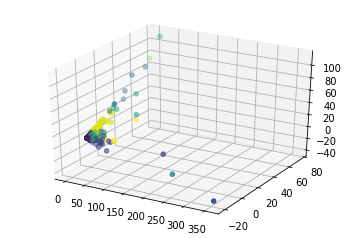

In [996]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

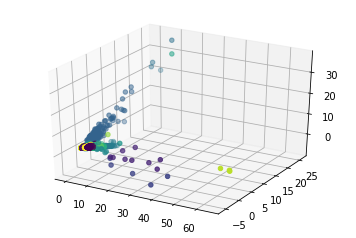

In [997]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [998]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [999]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [1000]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
1,8.739743e+05,4.032941e+04,6.240193e+06,1866.880663,1.331931e+09,4.082566e+05,2.333352e+06,2677.284378,2.906330e+08,6.676438e+05,...,2.415097e+07,17.764594,1.408845e+05,4.506934e+05,1.028345e+06,2.467210e+05,4.748266e+05,129.300372,7.354214e+04,14547
2,1.050838e+06,1.946850e+05,6.666936e+06,1407.682407,7.981048e+08,1.073079e+06,3.657223e+06,1789.269030,4.163120e+08,7.414127e+05,...,3.174375e+07,-6.176894,4.201898e+03,8.506054e+05,1.319950e+06,4.804377e+05,7.614349e+05,125.297567,1.645778e+05,9255
14,6.702179e+04,2.023922e+05,-5.619767e+06,2481.841570,1.430954e+09,1.170348e+06,-9.631984e+05,4432.376372,2.011608e+09,1.583096e+06,...,1.508355e+08,0.583673,-1.405765e+04,1.331117e+06,2.208119e+06,8.840034e+05,1.385927e+06,121.252701,7.957300e+04,4742
17,-8.011626e+05,2.403826e+05,1.040084e+07,5894.581932,8.195968e+08,1.517066e+06,6.776428e+06,-1240.700216,8.504481e+08,-2.836444e+05,...,6.232456e+07,-1.925830,-8.020312e+04,1.317081e+06,2.481921e+06,9.703303e+05,1.565404e+06,79.061445,4.528289e+04,4256
0,-1.635692e+06,3.629386e+05,-2.378579e+07,5640.254446,2.093960e+09,1.942079e+06,-6.517795e+06,7526.688935,4.791055e+09,2.810911e+06,...,3.561575e+08,-9.694304,-1.747964e+05,2.546998e+06,4.115135e+06,1.831460e+06,2.823265e+06,106.253642,3.557728e+03,1199
12,2.374431e+06,5.341604e+04,9.178941e+06,12809.111957,3.584116e+09,1.311730e+06,1.899782e+06,877.235510,9.397918e+08,-3.006788e+05,...,5.897796e+07,-49.700225,1.030334e+04,-1.929578e+05,7.682432e+05,3.307142e+05,7.257816e+05,219.902564,-1.720440e+04,1112
16,-4.191034e+06,4.881026e+05,1.786761e+07,12290.435107,6.691156e+08,3.597627e+06,1.364390e+07,-7779.550574,1.900533e+09,-2.070120e+06,...,1.324764e+08,-16.128487,-3.682203e+05,2.449753e+06,5.229713e+06,2.079990e+06,3.439808e+06,-11.466395,-1.085837e+05,662
18,1.178029e+06,6.111356e+05,4.702427e+07,62032.813489,8.048812e+09,1.601225e+07,1.432012e+07,29099.135135,1.131496e+09,8.993027e+06,...,1.660949e+07,9.504690,2.549247e+05,5.327232e+06,6.561474e+06,4.899135e+06,6.708954e+06,12.790639,9.583473e+05,99
4,6.058627e+06,6.802477e+06,9.903357e+07,23881.304160,2.804699e+10,-2.481920e+06,9.639048e+07,3135.834917,2.812901e+10,3.272422e+06,...,1.785233e+09,-49.595156,9.640024e+04,-7.403167e+05,-3.959436e+06,-7.950072e+06,-2.676914e+05,1994.806878,-1.533926e+06,18
6,2.008018e+07,5.105086e+06,1.551118e+08,332312.070402,2.041321e+10,9.312329e+07,8.485147e+07,164593.453058,9.413158e+09,4.971470e+07,...,-5.928392e+07,181.302837,1.169714e+05,2.165880e+07,-2.236671e+06,2.465528e+07,2.164961e+07,-2657.440157,1.719675e+06,6


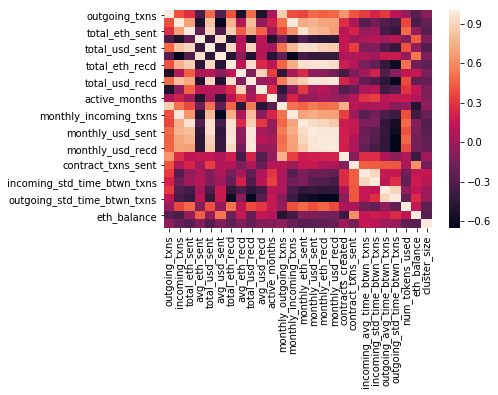

In [1001]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [1002]:
arr = df_summary.values

In [1003]:
arr.shape

(20, 26)

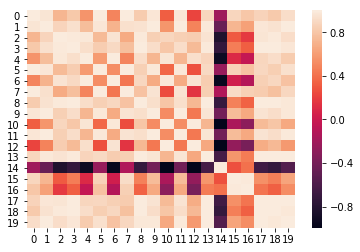

In [1004]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

In [1005]:
# for col in df_summary.columns:
#     df_summary[col].hist()
#     plt.title(col)
#     plt.show()

In [1006]:
p = PCA(n_components=3)

In [1007]:
vectors = p.fit_transform(arr[:8,:])

In [1008]:

xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

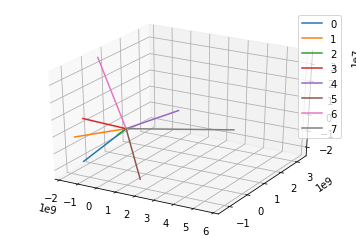

In [1009]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    ax.plot([0,x], [0,y],[0,z], label=i)
plt.legend()

In [1041]:
sql = '''
SELECT es.label,es.category, a.*  FROM `eth-tokens.test.clean_avg_with_balances_tokens` a
INNER JOIN `eth-tokens.alldata.etherscan_labelcloud` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''

dflabel = client.query(sql).to_dataframe()

In [1042]:
dflabel.shape

(126, 28)

In [1043]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [1044]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [1045]:
dflabel

,label,category,address,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster
0,Bgogo_1,Exchange,0x7a10ec7d68a048bdae36a70e93532d31423170fa,4634,42,55512.9469664,11.979487908,1.193449e+07,2.575420e+03,58124.066213484,...,4.162975e+06,0,0,1.383690e+05,1.409740e+05,1.257425e+03,4.127817e+03,5,486.335359084,1
1,Bgogo_2,Exchange,0xce1bf8e51f8b39e51c6184e059786d1c0eaf360f,36,5043,57900,1608.333333333,1.248853e+07,3.469036e+05,61671.7841197,...,4.418291e+06,0,0,9.234072e+02,1.880744e+04,1.373183e+05,1.435795e+05,16,4361.036312862,1
2,Rate3_Wallet2,ICO Wallets,0x841991ffe0dafd619bc517d82ee4700c37136140,7,5,5040,720,1.877741e+06,2.682487e+05,9684.7308,...,8.097912e+05,0,0,1.017963e+06,1.390813e+06,7.171660e+05,1.001970e+06,3,4644.727651874,1
3,Bitmax_1,Exchange,0x03bdf69b1322d623836afbd27679a1c0afa067e9,1061,1081,3348.282084541,3.155779533,7.798949e+05,7.350565e+02,6077.344511858,...,2.748006e+05,0,0,9.625878e+03,6.593208e+04,9.759738e+03,5.313994e+04,13,3871.119196898,1
4,Bitmax_2,Exchange,0x4b1a99467a284cc690e3237bc69105956816f762,3,1303,260,86.666666667,5.097040e+04,1.699013e+04,2958.985716476,...,1.608649e+05,0,0,8.146992e+03,1.386719e+05,1.307516e+06,1.848834e+06,3,2698.982399248,1
5,BigONE_1,Exchange,0xd4dcd2459bb78d7a645aa7e196857d421b10d93f,18665,13530,146649.064314301,7.856901383,5.504761e+07,2.949242e+03,157472.714797711,...,9.651075e+06,0,0,9.686476e+02,2.607501e+03,7.018620e+02,1.844994e+03,161,10262.461085817,12
6,Coinrail_Hack,Heist,0xf6884686a999f5ae6c1af03db92bab9c6d7dc8de,5,4,1693.512132673,338.702426535,3.760820e+05,7.521639e+04,8947,...,5.627703e+05,0,0,2.722357e+06,2.854648e+06,2.040091e+06,3.271049e+06,3,7446.134010779,1
7,Coinrail_Hack,Phish/Hack,0xf6884686a999f5ae6c1af03db92bab9c6d7dc8de,5,4,1693.512132673,338.702426535,3.760820e+05,7.521639e+04,8947,...,5.627703e+05,0,0,2.722357e+06,2.854648e+06,2.040091e+06,3.271049e+06,3,7446.134010779,1
8,Fake_Phishing1431,Phish/Hack,0xdf9191889649c442836ef55de5036a7b694115b6,9,7,13747,1527.444444444,4.363486e+06,4.848317e+05,15526.883550987,...,6.351271e+05,0,0,1.372057e+06,2.722141e+06,1.035478e+06,1.945720e+06,15,11371.001874184,1
9,IDEX_2,Dex,0xa7a7899d944fe658c4b0a1803bab2f490bd3849e,217,126,0,0,0.000000e+00,0.000000e+00,4442.599147341,...,2.488918e+05,0,0,1.128669e+05,2.318753e+05,8.412037e+00,3.410288e+01,22,118.957424939,1


In [1047]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label','category']])
    print('\n\n\n')

cluster 0
labelled points: 0
total points: 1199
Empty DataFrame
Columns: [label, category]
Index: []




cluster 1
labelled points: 34
total points: 14547
                    label     category
0                 Bgogo_1     Exchange
1                 Bgogo_2     Exchange
2           Rate3_Wallet2  ICO Wallets
3                Bitmax_1     Exchange
4                Bitmax_2     Exchange
6           Coinrail_Hack        Heist
7           Coinrail_Hack   Phish/Hack
8       Fake_Phishing1431   Phish/Hack
9                  IDEX_2          Dex
10      Fake_Phishing1746   Phish/Hack
13               Huobi_16     Exchange
14       Perlin_TokenSale   Token Sale
15               Huobi_15     Exchange
16            INCX_Wallet  ICO Wallets
17        Airbloc_Wallet2  ICO Wallets
18          Rate3_Wallet1  ICO Wallets
20                    Uex     Exchange
25       Fake_Phishing631   Phish/Hack
28          Dether_Wallet  ICO Wallets
31    Lendingblock_Wallet  ICO Wallets
32       Fake_Phishing638 

centralization of ownership

In [1048]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

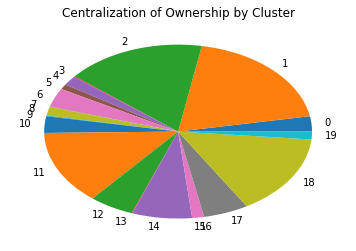

In [1049]:
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

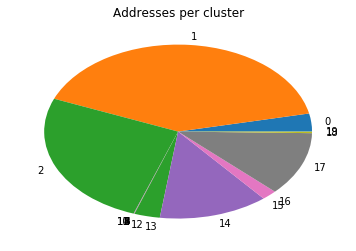

In [1050]:
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.show()

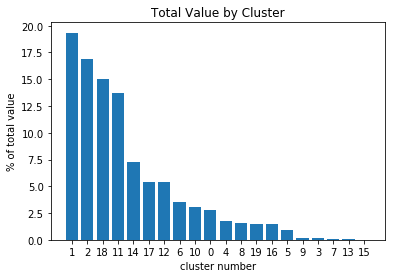

In [1051]:

names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster')
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.show()




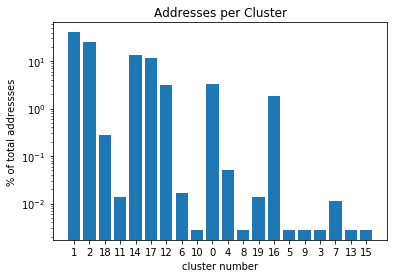

In [1052]:

names = np.array(list(total_addresses.keys()))
values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.bar(range(len(total_addresses)),values/sum(values)*100,tick_label=names)
plt.title('Addresses per Cluster')
plt.yscale('log')
plt.xlabel('cluster number')
plt.ylabel('% of total addressses')
plt.show()

cluster 0


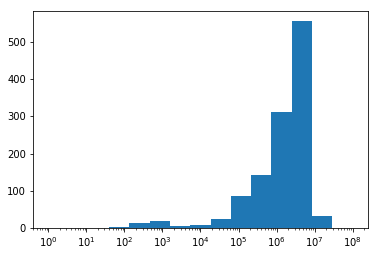

cluster 1


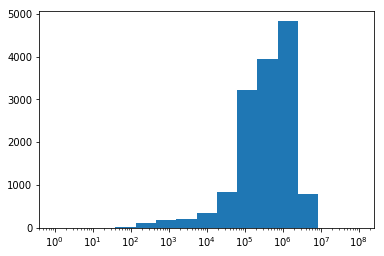

cluster 2


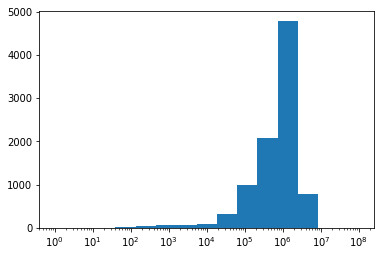

cluster 3


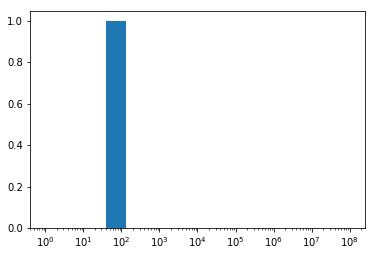

cluster 4


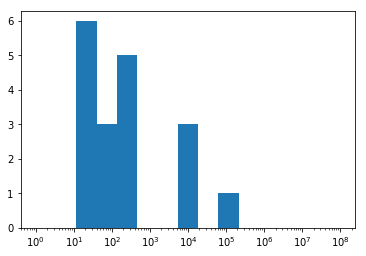

cluster 5


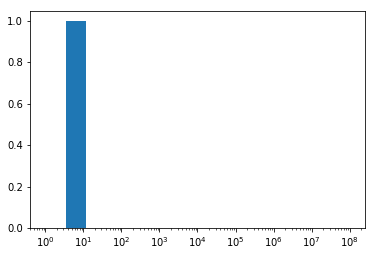

cluster 6


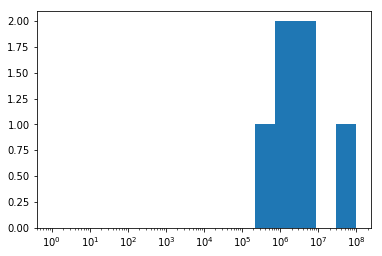

cluster 7


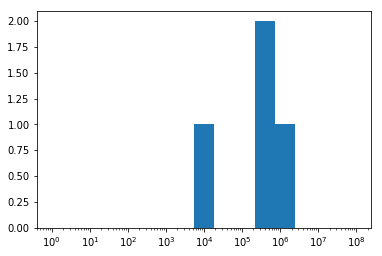

cluster 8


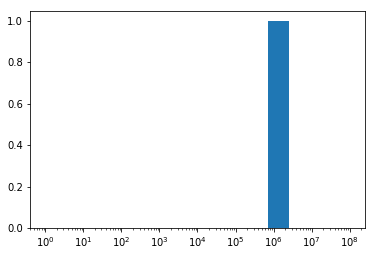

cluster 9


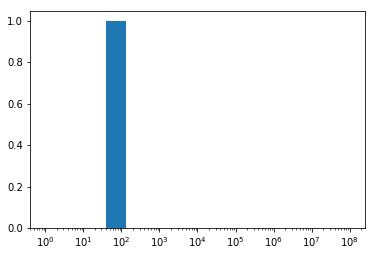

cluster 10


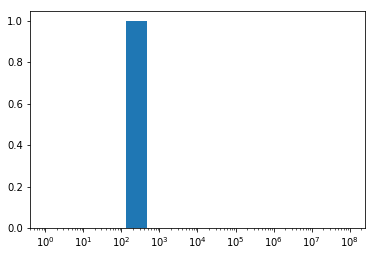

cluster 11


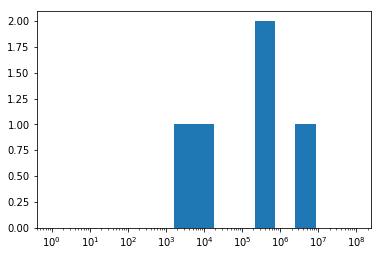

cluster 12


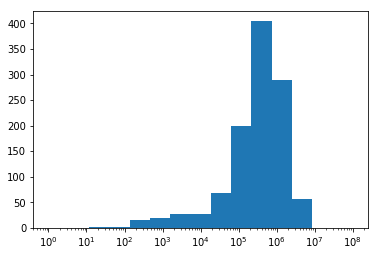

cluster 13


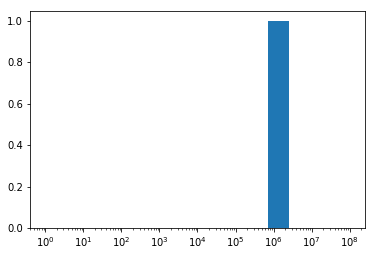

cluster 14


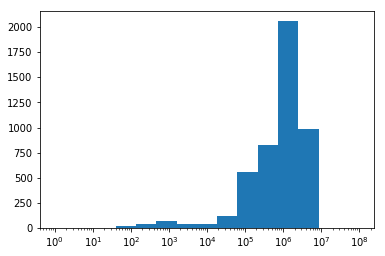

cluster 15


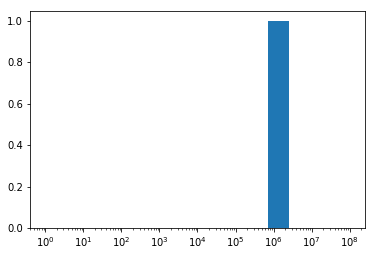

cluster 16


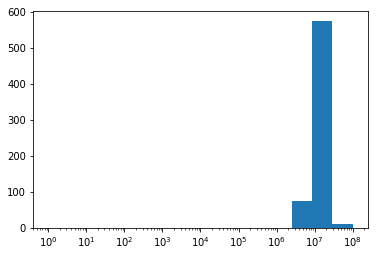

cluster 17


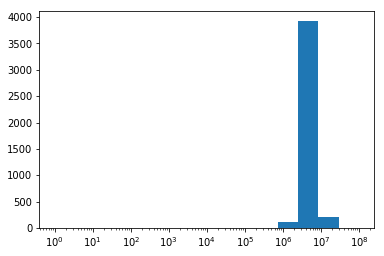

cluster 18


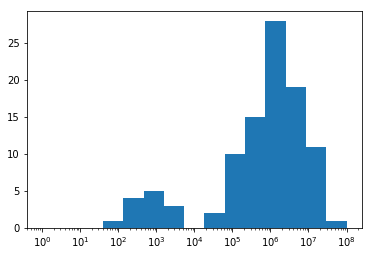

cluster 19


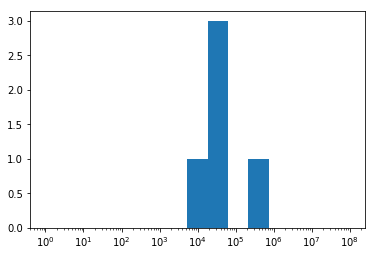

In [1053]:
col = 1

for clust in range(cl.n_clusters):
    cluster_data = df[cl.labels_==clust]
    print('cluster {}'.format(clust))
    logbins = np.logspace(0,8,16)
    plt.hist(cluster_data['incoming_avg_time_btwn_txns'], bins=logbins)
    plt.xscale('log')
    plt.show()
    

In [1057]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

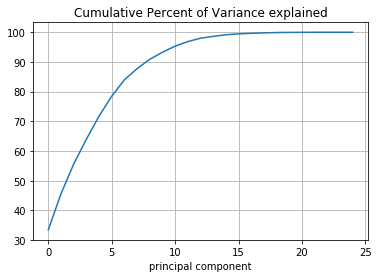

In [1058]:
pca = pipe.named_steps['PCA']
plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

Text(0.5,1,'Calinski Harabaz Scores')

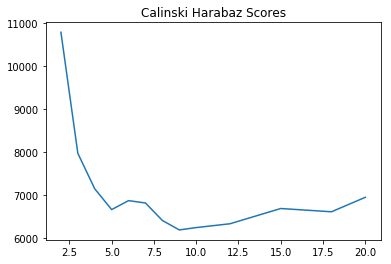

In [1060]:
#scoring metric?
clusters = [2,3,4,5,6,7,8,9,10,12,15,18,20]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

In [1061]:
cl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [cl.labels_[i] for i in range(len(dflabel))]

In [1062]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results = tsne.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 126 samples in 0.000s...
[t-SNE] Computed neighbors for 126 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 126 / 126
[t-SNE] Mean sigma: 0.889477
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.865013
[t-SNE] Error after 1200 iterations: 0.246859
t-SNE done! Time elapsed: 1.5523195266723633 seconds


Text(0,0.5,'second principcal component')

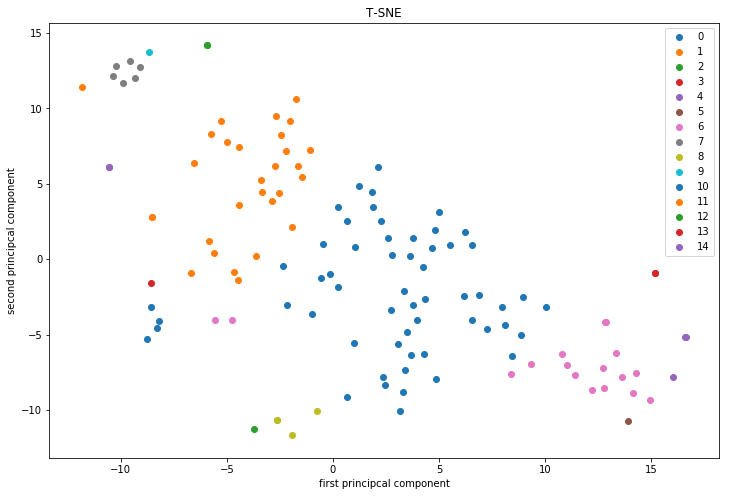

In [1063]:
plt.figure(figsize=(12,8))
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principcal component')
plt.ylabel('second principcal component')

In [1064]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label', 'category']])
    print('\n\n\n')

cluster 0
labelled points: 53
total points: 53
                     label     category
0                  Bgogo_1     Exchange
1                  Bgogo_2     Exchange
2            Rate3_Wallet2  ICO Wallets
3                 Bitmax_1     Exchange
4                 Bitmax_2     Exchange
5                 BigONE_1     Exchange
8        Fake_Phishing1431   Phish/Hack
9                   IDEX_2          Dex
10       Fake_Phishing1746   Phish/Hack
12               Gate.io_3     Exchange
13                Huobi_16     Exchange
14        Perlin_TokenSale   Token Sale
15                Huobi_15     Exchange
16             INCX_Wallet  ICO Wallets
17         Airbloc_Wallet2  ICO Wallets
18           Rate3_Wallet1  ICO Wallets
19               Gate.io_2     Exchange
20                     Uex     Exchange
23                  Bilaxy     Exchange
25        Fake_Phishing631   Phish/Hack
26              BitUN.io_2     Exchange
27                    Cobo   Wallet App
28           Dether_Wallet  ICO W